<a href="https://colab.research.google.com/github/hy30n80/KERC2022/blob/main/Model6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash



--2022-09-20 10:28:19--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-09-20 10:28:21--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccc5db08d51e8daa5901f3c8b15.dl.dropboxusercontent.com/cd/0/get/BtQyVqt96BFjPOHRJsSA-TGQzw6dk6VqjZNfLpXMBKVwCC2pcrN3YIinBHuWBMWkHz6N7nwMz9_yPePKyZY4IWtXNAAIIcvih_cVU-stR6UCHtaDWib3-5ukvL27zfFZ1R3oYpuuSouVFnf-MHA55TgyCUR5kXcHrOCzpmA4xk9WbQjOwy_ZtskkqCFNoQy3ZEE/file?dl=1# [following]
--2022-09-20 10:28:22--  https://uccc5db08d51e8daa5901f3c8b15.dl.dropboxusercontent.com/cd/0/get/BtQyVqt96B

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from konlpy.tag import Okt, Mecab
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm
from tensorflow.keras.layers import(Input, Dense, Bidirectional, LSTM, Concatenate, concatenate, Embedding, Dropout)
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import sklearn

Mounted at /content/drive


In [3]:
train_x_path = '/content/drive/MyDrive/KERC2022/KERC22Dataset_PublicTest/train_data.tsv'
train_y_path = '/content/drive/MyDrive/KERC2022/KERC22Dataset_PublicTest/train_labels.csv'

In [4]:
EMBEDDING_DIM=100
MAXLEN_S = 12
MAXLEN_C = 10
TRUNCATING = 'post'
PADDING = 'pre'
OOV_TOKEN = '<OOV>'
NUM_WORDS = 10000
SPLIT_SIZE = 0.9

In [5]:
train_data = pd.read_csv(train_x_path, sep='\t')
labels = pd.read_csv(train_y_path)
#label csv 를 train_data에 병합
train_data['label'] = labels['label']
print(train_data[:5])
print(len(train_data))
print(train_data.isnull().sum())

   sentence_id person                                           sentence  \
0            1     어영  야! 전화 받아. 아무리 바빠도 내전화는 받아야 되는거 아냐? 약속 하나도 못지키는...   
1            2     어영     우리 아무래도 안되겠다. 이게 최선인거 같애. 평생 잊지 않을게. 행복하길 바란다.   
2            3    지구대                          김경사님, 아직 안가셨어요? 시간 다됐을텐데.   
3            4     순경                                         근무중인데 어딜가?   
4            5    지구대    다녀오세요. 이런날은 무조건 가서 축하해주셔야죠. 이순경이 대신 근무선다고 나온대요.   

   scene                                          context      label  
0  S0104                                              NaN  dysphoria  
1  S0108         포기한듯 탁 일어서는데, 띵동 문자. 후다닥 보는 어영. 기막혀 읽어보는  dysphoria  
2  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대    neutral  
3  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대  dysphoria  
4  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대   euphoria  
7339
sentence_id       0
person            0
sentence          0
scene             0
context        2017
label       

In [6]:
#context null 값 '결측' 으로 채우기
train_data['context'].fillna('결측', inplace=True)
print(train_data.isnull().sum())

sentence_id    0
person         0
sentence       0
scene          0
context        0
label          0
dtype: int64


In [7]:
# person, scene category 변형
train_data['person'].value_counts()
train_data['scene'].value_counts()


train_data['person'] = train_data['person'].astype('category')
train_data['scene'] = train_data['scene'].astype('category')


train_data['person']= train_data['person'].cat.codes
train_data['scene']= train_data['scene'].cat.codes
print(train_data[:5])

   sentence_id  person                                           sentence  \
0            1      42  야! 전화 받아. 아무리 바빠도 내전화는 받아야 되는거 아냐? 약속 하나도 못지키는...   
1            2      42     우리 아무래도 안되겠다. 이게 최선인거 같애. 평생 잊지 않을게. 행복하길 바란다.   
2            3      69                          김경사님, 아직 안가셨어요? 시간 다됐을텐데.   
3            4      36                                         근무중인데 어딜가?   
4            5      69    다녀오세요. 이런날은 무조건 가서 축하해주셔야죠. 이순경이 대신 근무선다고 나온대요.   

   scene                                          context      label  
0      0                                               결측  dysphoria  
1      1         포기한듯 탁 일어서는데, 띵동 문자. 후다닥 보는 어영. 기막혀 읽어보는  dysphoria  
2      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대    neutral  
3      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대  dysphoria  
4      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대   euphoria  


In [8]:
#전체 data 셔플

train_data=sklearn.utils.shuffle(train_data)
print(train_data)


      sentence_id  person                                           sentence  \
5505         9204       1                                             내가 언제?   
3048         5213      59                                                 건배   
1134         1854      36                                                뭐야?   
1122         1842      36        당신이 이모양으로 감싸고 도니까 그모양 그꼬라지 아냐? 말나온김에 해봐 어디!   
5898         9838      83                                             거긴 안돼.   
...           ...     ...                                                ...   
6911        11519      23                   아부지가 챙피해. 그런 아부지 밑에서 태어난게 후회스러워.   
2222         3695      17                                    어젯밤에 연락도 안받으시고.   
794          1321      62                                  최선 다해 해보겠습니다 부장님.   
1151         1871      36                                    야, 니엄마 델꼬 들어가라.   
6485        10862      42  예. 부영이도 교육받으러 들어간댔고, 아줌마도 나간다고 했으니 집에 혼자 계시겠네요...   

      scene                            

In [9]:
# Stopwords 는 우선 고려하지 않고 실행
# sentence , context 문자열 데이터로 처리
okt = Okt()
mecab = Mecab()

tok_sentences = []
for sen in tqdm(train_data['sentence']):
  tok_sen = mecab.morphs(sen)
  tok_sentences.append(tok_sen)

tok_contexts = []
for con in tqdm(train_data['context']):
  tok_con = mecab.morphs(con)
  tok_contexts.append(tok_con)

100%|██████████| 7339/7339 [00:00<00:00, 13202.01it/s]


[['내', '가', '언제', '?'], ['건배'], ['뭐', '야', '?'], ['당신', '이', '이', '모양', '으로', '감싸', '고', '도', '니까', '그', '모양', '그', '꼬라지', '아냐', '?', '말', '나온', '김', '에', '해', '봐', '어디', '!'], ['거긴', '안', '돼', '.']]
문장 최대 길이:  81
문장 평균 길이:  15.150837988826815


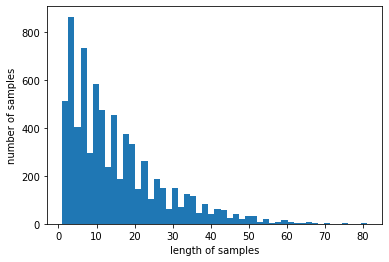

문맥 최대 길이:  6
문맥 평균 길이:  12.907344324839896


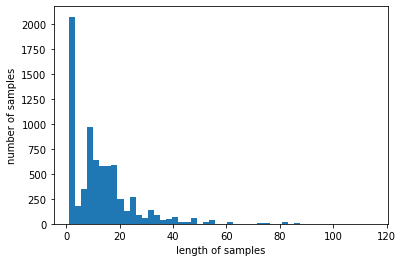

In [10]:
print(tok_sentences[:5])

print('문장 최대 길이: ', max(len(sen) for sen in tok_sentences))
print('문장 평균 길이: ', sum(map(len, tok_sentences))/len(tok_sentences))
plt.hist([len(sen) for sen in tok_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('문맥 최대 길이: ', max(len(con) for sen in tok_contexts))
print('문맥 평균 길이: ', sum(map(len, tok_contexts))/len(tok_contexts))
plt.hist([len(con) for con in tok_contexts], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()



In [11]:
# sentence, context 을 통재로 묶어서 tokenize 만들고, 각각 적용
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def fit_and_seq(train_sentences, train_contexts, oov_token, maxlen_s, maxlen_c , padding, truncating):
  train_set = np.concatenate((train_sentences, train_contexts), axis=0)
  tokenizer = Tokenizer(oov_token = oov_token)
  tokenizer.fit_on_texts(train_set)
  
  sen_seq= tokenizer.texts_to_sequences(train_sentences)
  con_seq = tokenizer.texts_to_sequences(train_contexts)
  pad_sen_sequences= pad_sequences(sen_seq, maxlen=maxlen_s, padding=padding, truncating=truncating)
  pad_con_sequences= pad_sequences(con_seq, maxlen=maxlen_c, padding=padding, truncating=truncating)

  return pad_sen_sequences, pad_con_sequences, tokenizer

"""
def tokenize_label(labels):

  label_tokenizer = Tokenizer()
  label_tokenizer.fit_on_texts(labels)

  label_seq = label_tokenizer.texts_to_sequences(labels)
  label_seq_np = np.array(label_seq)-1

  return label_seq_np, label_tokenizer
"""


'\ndef tokenize_label(labels):\n\n  label_tokenizer = Tokenizer()\n  label_tokenizer.fit_on_texts(labels)\n\n  label_seq = label_tokenizer.texts_to_sequences(labels)\n  label_seq_np = np.array(label_seq)-1\n\n  return label_seq_np, label_tokenizer\n'

In [12]:
train_sentence_seq, train_context_seq, tokenizer = fit_and_seq(tok_sentences, tok_contexts, OOV_TOKEN, MAXLEN_S, MAXLEN_C, PADDING, TRUNCATING)
word_index = tokenizer.word_index

print(train_sentence_seq.shape)
print(train_context_seq.shape)
print(train_sentence_seq[3])
print(train_context_seq[3])

print(word_index.items())

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(7339, 12)
(7339, 10)
[ 235    8    8  636   44 2497    4   16  164   68  636   68]
[   0 1707 1177  258    4  368   22    7   59  581]
dict_items([('<OOV>', 1), ('.', 2), ('는', 3), ('고', 4), ('하', 5), ('?', 6), (',', 7), ('이', 8), ('에', 9), ('가', 10), ('은', 11), ('측', 12), ('결', 13), ('어', 14), ('이상', 15), ('도', 16), ('보', 17), ('들', 18), ('다', 19), ('지', 20), ('어영', 21), ('우미', 22), ('게', 23), ('안', 24), ('거', 25), ('들오', 26), ('건강', 27), ('면', 28), ('난', 29), ('해', 30), ('있', 31), ('현찰', 32), ('며', 33), ('을', 34), ('나', 35), ('에서', 36), ('아', 37), ('청', 38), ('앉', 39), ('말', 40), ('한', 41), ('서', 42), ('나오', 43), ('으로', 44), ('야', 45), ('는데', 46), ('과자', 47), ('순경', 48), ('겠', 49), ('내', 50), ('먹', 51), ('사람', 52), ('범인', 53), ('뭐', 54), ('만', 55), ('없', 56), ('니', 57), ('오', 58), ('놓', 59), ('알', 60), ('좋', 61), ('일', 62), ('주', 63), ('좀', 64), ('재수', 65), ('했', 66), ('냐', 67), ('그', 68), ('자', 69), ('못', 70), ('로', 71), ('왜', 72), ('얼른', 73), ('님', 74), ('잘', 75), ('던', 76), ('되',

In [13]:
'''
#embedding matrix 압축해제
%cd /content/drive/MyDrive/KERC2022
!unzip -qq "/content/drive/MyDrive/KERC2022/word-embeddings.zip"
'''

'\n#embedding matrix 압축해제\n%cd /content/drive/MyDrive/KERC2022\n!unzip -qq "/content/drive/MyDrive/KERC2022/word-embeddings.zip"\n'

In [14]:
embedding_dict = dict()
f=open('/content/drive/MyDrive/KERC2022/word-embeddings/glove/glove.txt', encoding="utf8")

for line in f:
  word_vector = line.split()
  word = word_vector[0]

  word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
  embedding_dict[word]=word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' %len(embedding_dict))


358043개의 Embedding vector가 있습니다.


In [15]:
#100차원 embedding
print(len(embedding_dict['잘']))

100


In [16]:
embedding_matrix = np.zeros((NUM_WORDS, 100))
print(np.shape(embedding_matrix))


(10000, 100)


In [17]:
print(word_index.items())
print('단어 word index 가 4인 고에 대한 임베딩 벡터:', embedding_dict['고'])

dict_items([('<OOV>', 1), ('.', 2), ('는', 3), ('고', 4), ('하', 5), ('?', 6), (',', 7), ('이', 8), ('에', 9), ('가', 10), ('은', 11), ('측', 12), ('결', 13), ('어', 14), ('이상', 15), ('도', 16), ('보', 17), ('들', 18), ('다', 19), ('지', 20), ('어영', 21), ('우미', 22), ('게', 23), ('안', 24), ('거', 25), ('들오', 26), ('건강', 27), ('면', 28), ('난', 29), ('해', 30), ('있', 31), ('현찰', 32), ('며', 33), ('을', 34), ('나', 35), ('에서', 36), ('아', 37), ('청', 38), ('앉', 39), ('말', 40), ('한', 41), ('서', 42), ('나오', 43), ('으로', 44), ('야', 45), ('는데', 46), ('과자', 47), ('순경', 48), ('겠', 49), ('내', 50), ('먹', 51), ('사람', 52), ('범인', 53), ('뭐', 54), ('만', 55), ('없', 56), ('니', 57), ('오', 58), ('놓', 59), ('알', 60), ('좋', 61), ('일', 62), ('주', 63), ('좀', 64), ('재수', 65), ('했', 66), ('냐', 67), ('그', 68), ('자', 69), ('못', 70), ('로', 71), ('왜', 72), ('얼른', 73), ('님', 74), ('잘', 75), ('던', 76), ('되', 77), ('어요', 78), ('너', 79), ('었', 80), ('부영', 81), ('솔', 82), ('한테', 83), ('아니', 84), ('요', 85), ('아부지', 86), ('받', 87), ('할', 88), ('집

In [18]:
for word, index in tokenizer.word_index.items():
  vector_value = embedding_dict.get(word)
  if vector_value is not None:
    embedding_matrix[index]= vector_value

In [19]:
embedding_matrix[4]

array([-1.11049294e+00, -6.02223992e-01,  5.71654022e-01, -3.61927003e-01,
        7.45339990e-02, -7.51710013e-02, -9.82264996e-01, -3.60437989e-01,
       -1.58338594e+00, -8.54599997e-02, -1.71569996e-02,  1.11514902e+00,
       -5.17001987e-01, -7.87141025e-01, -8.30124974e-01,  4.60023999e-01,
        7.49590024e-02,  3.69709991e-02,  6.60499977e-03,  1.49837002e-01,
        2.37296009e+00,  2.93150008e-01,  2.54455000e-01, -8.94550011e-02,
        3.52138996e-01, -1.35179996e-01,  2.52279013e-01,  4.24050018e-02,
       -8.60870034e-02,  3.39881986e-01, -1.65535003e-01, -5.74100018e-03,
       -1.34199997e-03,  5.74189983e-02,  3.51019986e-02, -4.19905990e-01,
        2.02687994e-01,  6.51202977e-01,  8.13265979e-01,  3.16426009e-01,
       -5.41135013e-01, -3.91431004e-01, -1.28048003e-01,  2.03174993e-01,
        5.35090983e-01,  1.14778197e+00, -4.43010986e-01, -1.27355897e+00,
        1.38452601e+00,  4.50946003e-01, -9.98980030e-02,  1.03630997e-01,
        5.87269999e-02, -

In [20]:
#label 값 0,1,2 로 Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le = le.fit(train_data['label'])

train_label_seq = le.transform(train_data['label'])
print(le.classes_)
print(train_data['label'][:10])
print(train_label_seq[:10])

#dysphoria:0, euphoria:1, neutral:2

['dysphoria' 'euphoria' 'neutral']
5505    dysphoria
3048     euphoria
1134    dysphoria
1122    dysphoria
5898    dysphoria
2089    dysphoria
7235    dysphoria
3898    dysphoria
5870     euphoria
2467      neutral
Name: label, dtype: object
[0 1 0 0 0 0 0 0 1 2]


In [21]:
"""
def train_val_split(sentences, labels, training_split):

  train_size = int(len(sentences)*training_split)

  train_sentences = sentences[:train_size]
  train_labels = labels[:train_size]


  val_sentences = sentences[train_size:]
  val_labels = labels[train_size:]

  return train_sentences, train_labels, val_sentences, val_labels
"""

'\ndef train_val_split(sentences, labels, training_split):\n\n  train_size = int(len(sentences)*training_split)\n\n  train_sentences = sentences[:train_size]\n  train_labels = labels[:train_size]\n\n\n  val_sentences = sentences[train_size:]\n  val_labels = labels[train_size:]\n\n  return train_sentences, train_labels, val_sentences, val_labels\n'

In [22]:
print(type(np.array(train_data['person'])), type(train_sentence_seq),type(train_context_seq), type(train_data['scene']) )

print(np.array(train_data['person']).shape)
print(train_sentence_seq.shape)
print(np.array(train_data['person']))
print(train_sentence_seq)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
(7339,)
(7339, 12)
[ 1 59 36 ... 62 36 42]
[[   0    0    0 ...   10  273    6]
 [   0    0    0 ...    0    0 2759]
 [   0    0    0 ...   54   45    6]
 ...
 [   0    0 2705 ... 1473   74    2]
 [   0    0    0 ...  276  136    2]
 [ 104    2 1682 ...    4    7  363]]


In [23]:
#Data split 
from sklearn.model_selection import train_test_split
train_sentences, test_sentences = train_test_split(train_sentence_seq, test_size=0.1, shuffle=False)
train_contexts, test_contexts = train_test_split(train_context_seq, test_size=0.1, shuffle=False)
train_people, test_people = train_test_split(np.array(train_data['person']), test_size=0.1, shuffle=False)
train_scenes, test_scenes = train_test_split(np.array(train_data['scene']), test_size=0.1, shuffle=False)
train_labels, test_labels = train_test_split(train_label_seq, test_size=0.1, shuffle=False)

In [24]:

print(train_sentences.shape)
print(train_contexts.shape)
print(train_people.shape)
print(train_scenes.shape)
print(train_labels.shape)

print(test_sentences.shape)
print(test_contexts.shape)
print(test_people.shape)
print(test_scenes.shape)
print(test_labels.shape)



(6605, 12)
(6605, 10)
(6605,)
(6605,)
(6605,)
(734, 12)
(734, 10)
(734,)
(734,)
(734,)


In [25]:
def create_model(num_words, embedding_dim, maxlen_s, maxlen_c):
  

  input_P = Input(shape=[1], name = "input_person")
  input_S = Input(shape=[1], name = "input_scene")
  input_sen = Input(shape=[maxlen_s], name = "input_sentence")
  input_con = Input(shape=[maxlen_c], name = "input_context")

  Dense_p1 = Dense(8, activation = 'relu')(input_P)
  Dense_p2 = Dense(4, activation = 'sigmoid')(Dense_p1)

  Dense_s1 = Dense(4, activation = 'relu')(input_S)
  Dense_s2 = Dense(4, activation = 'sigmoid')(Dense_s1)

  Embedding1 = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen_s, trainable=False)(input_sen)
  LSTM_sen1 = Bidirectional(LSTM(16, return_sequences=True))(Embedding1)
  LSTM_sen2 = Bidirectional(LSTM(16, return_sequences=False))(LSTM_sen1)
  Dense_sen = Dense(16, activation = 'sigmoid')(LSTM_sen2)

  Embedding2 = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen_c, trainable=False)(input_con)
  LSTM_con1 = Bidirectional(LSTM(16, return_sequences=True))(Embedding2)
  LSTM_con2 = Bidirectional(LSTM(16, return_sequences=False))(LSTM_con1)
  Dense_con = Dense(16, activation = 'sigmoid')(LSTM_con2)

  
  concat = concatenate([Dense_p2, Dense_s2, Dense_sen, Dense_con], name='concat')
  Dense1 = Dense(16, activation = 'relu')(concat)
  Drp1 = Dropout(0.2)(Dense1)
  Dense2 = Dense(8, activation = 'sigmoid')(Drp1)
  Drp2 = Dropout(0.2)(Dense2)
  output = Dense(3, activation = 'softmax')(Dense2)


  model = tf.keras.Model(inputs =[input_P, input_S, input_sen, input_con], outputs=[output])


  return model


In [26]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN_S, MAXLEN_C)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentence (InputLayer)    [(None, 12)]         0           []                               
                                                                                                  
 input_context (InputLayer)     [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 12, 100)      1000000     ['input_sentence[0][0]']         
                                                                                                  
 embedding_1 (Embedding)        (None, 10, 100)      1000000     ['input_context[0][0]']          
                                                                                              

In [28]:
"""
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4*10**(epoch/10))
"""

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)


In [29]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
history = model.fit((train_people, train_scenes, train_sentences, train_contexts), train_labels, epochs=200, 
                    validation_data = ((test_people, test_scenes, test_sentences, test_contexts), test_labels))

Epoch 1/200
207/207 [==============================] - 10s 46ms/step - loss: 0.4354 - accuracy: 0.8416 - val_loss: 0.7766 - val_accuracy: 0.7125
Epoch 2/200
207/207 [==============================] - 7s 33ms/step - loss: 0.4352 - accuracy: 0.8433 - val_loss: 0.7845 - val_accuracy: 0.7084
Epoch 3/200
207/207 [==============================] - 7s 33ms/step - loss: 0.4328 - accuracy: 0.8465 - val_loss: 0.7962 - val_accuracy: 0.7166
Epoch 4/200
207/207 [==============================] - 7s 33ms/step - loss: 0.4337 - accuracy: 0.8438 - val_loss: 0.7948 - val_accuracy: 0.7057
Epoch 5/200
207/207 [==============================] - 7s 33ms/step - loss: 0.4252 - accuracy: 0.8494 - val_loss: 0.7949 - val_accuracy: 0.7139
Epoch 6/200
207/207 [==============================] - 7s 33ms/step - loss: 0.4253 - accuracy: 0.8475 - val_loss: 0.7870 - val_accuracy: 0.7207
Epoch 7/200
207/207 [==============================] - 7s 33ms/step - loss: 0.4294 - accuracy: 0.8442 - val_loss: 0.7898 - val_accuracy

KeyboardInterrupt: ignored

In [31]:
result = model.predict((train_people, train_scenes, train_sentences, train_contexts))
predict = tf.argmax(result, axis=1)
print(predict)

tf.Tensor([0 1 0 ... 0 1 1], shape=(6605,), dtype=int64)
